## Introduction to Interpreted GenJAX

This notebook will give a tour of the interpreted dialect of GenJAX, the probabilistic computing system developed by the [MIT Probabilistic Computing Laboratory](http://probcomp.csail.mit.edu/).

GenJAX provides two dialects for writing probabilistic programs.  The _static_ dialect is designed to be compiled to run on GPUs (or CPUs); a tutorial on the static dialect is available [here](intro_to_genjax.ipynb).  The _interpreted_ dialect is designed to be run on CPUs only, through the Python interpreter; it is the subject of this notebook.

The static dialect of GenJAX is more restricted than the interpreted dialect, to enable compilation to GPUs and other hardware platforms, using [JAX](https://jax.readthedocs.io/).  For instance, one restriction is that native Python control flow cannot be used; instead, static GenJAX programs must use a different representation for branching computation that is compatible with JAX's approach to GPU compilation.

The interpreted dialect of GenJAX can be used to write probabilistic programs without these restrictions.  (The downside is that interpreted GenJAX programs run much more slowly, since they run through the Python interpreter and do not utilize GPU parallelism.)  The interpreted dialect is intended (1) to facilitate learning to use GenJAX, (2) to facilitate rapid prototyping, and (3) to make it easier to write models and inference algorithms in applications where performance is not a bottleneck. 

For the present, we'll set those concerns aside and proceed with a simple inference task in the easy-going interpreted dialect.

In [1]:
import genjax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from genjax import interpreted_gen_fn

key = jax.random.PRNGKey(314159)
console = genjax.console(enforce_checkify=True, width=60)

A few notes about the prefatory material above. GenJAX uses JAX, and JAX provides its own flavor of numpy, which we will call `jnp` in this notebook. The main difference between jnp and numpy is that vectors and tensors are immutable once constructed: instead of changing them, you must make a copy with the updates you require. We could use regular numpy in the interpreted dialect, but it turns out that it's not difficult to work with jnp even in the interpreted case.

GenJAX allows the production of reproducible scientific work through the use of a "splittable" random number generator. You can set the initial seed of the generator as we have done above. Then, when we need random numbers within a function, we will split the generator and hand one fork to the function and keep the other fork at the topmost level. In this way, provided that the notebook cells are evaluated from top to bottom, all the random choices will be made in the same way each time. We encourage this technique for your own work to produce reproducible scientific communication.

Let's create our first generative function:

In [2]:
@interpreted_gen_fn
def g(x):
    b = genjax.flip(x) @ "b"
    return b

The `@interpreted` decoration is a bridge between an ordinary Python function and the [Generative Function](https://www.gen.dev/docs/stable/ref/gfi/#Generative-Functions) interface, which is at the heart of the Gen model of probabilistic programming. You can regard the `@` sign as something like the $\sim$ operator in statistics. (That is, `distribution @ "b"` roughly means $b \sim \text{distribution}$).  In the above code, `genjax.flip(x) @ b` describes $b$ as a random variable with a $\text{Bernoulli}(x)$ distribution (like tossing a coin with $x$ as the probability of heads). The GenJAX system uses the string name `"b"` to record the name of the random variable; it cannot see the name of the Python variable to which you assigned the value, but of course it's convenient to use the same name in both cases.

(Note that in addition to `genjax.flip`, there is a `genjax.bernoulli` distribution, but its argument is the log odds $\log \frac{p}{1-p}$, rather than the probability $p$.)

The `@interpreted` decoration has equipped our function $g$ with the method `simulate`, which will draw a value from the distribution:

In [3]:
key, sub_key = jax.random.split(key)
tr = g.simulate(sub_key, (0.3,))
console.print(tr)

InterpretedTrace
├── gen_fn
│   └── InterpretedGenerativeFunction
│       └── source
│           └── <function g>
├── args
│   └── tuple
│       └── (const) 0.3
├── retval
│   └──  i32[]
├── choices
│   └── Trie
│       └── :b
│           └── DistributionTrace
│               ├── gen_fn
│               │   └── TFPDistribution
│               │       └── make_distribution
│               │           └── <function <lambda>>
│               ├── args
│               │   └── tuple
│               │       └── (const) 0.3
│               ├── value
│               │   └──  i32[]
│               └── score
│                   └──  f32[]
└── score
    └──  f32[]

Running the function has produced a tree structure called a _trace_ which records the result of random choices made during the function's execution. As generative functions call other generative functions, the trace will become more elaborate. The value itself is in an array; to see it, we can call 

In [4]:
tr.get_retval()

Array(1, dtype=int32)

If we'd like to draw more of a sample, we'll need more subkeys to get the randomness we need.  We can implement this as follows:

In [5]:
n_samples = 20
key, *sub_keys = jax.random.split(key, n_samples + 1)
[g.simulate(k, (0.3,)).get_retval().item() for k in sub_keys]

[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

### Compound Models
Our little function `g` didn't do much: it was just a wrapper for `genjax.flip`, which is already a generative function.  Now we will create some more involved generative functions that mix distributions in more interesting ways. We will ultimately combine these generative functions in a top-level generative function, `model`, which models data noisly distributed around a quadratic function, with some outliers.  After writing this model, we will write an inference algorithm which can infer the coefficients of the quadratic function while automatically classifying outliers.  (One benefit of outlier classification is that the inferred possible quadradic functions underlying the data will be less skewed by the outliers.)

In [6]:
def polynomial(coefficients):
    """Given coefficients of a polynomial a_0, a_1, ..., return a function
    computing a_0 x^0 + a_1 x^1 + ..."""

    def f(x):
        powers_of_x = jnp.array([x**i for i in range(len(coefficients))])
        return jnp.sum(coefficients * powers_of_x)

    return f


@interpreted_gen_fn
def model_y(x, f):
    """Given x and f, model f(x) plus a small amount of gaussian noise."""
    y = genjax.normal(f(x), 0.3) @ "value"
    return y


@interpreted_gen_fn
def outlier_model(x, f):
    """Like model_y, except this time we allow a huge variance in the noise,
    to model an outlying value"""
    y = genjax.normal(f(x), 30.0) @ "value"
    return y

Now we have a generative functions for a polynomial model with inliers and outliers. The next step is to _generate_ candidate polynomials with inlying and outlying points by welding these small generative functions together into a more elaborate model which represents our prior belief about the structure of the data we might observe. This involves flipping an (unfair) coin to determine whether we have an inlier or outlier.  This generative function then draws a sample from one of the previously defined generative functions, depending on the result of the coin flip.

In [7]:
@interpreted_gen_fn
def kernel(xs, f):
    y = []
    for i, x in enumerate(xs):
        is_outlier = genjax.flip(0.1) @ ("outlier", i)

        if is_outlier:
            model = outlier_model
        else:
            model = model_y

        y.append(model(x, f) @ ("y", i))

    return jnp.array(y)

We pause here to note one universal feature of GenJAX: you must give every traced value a unique name. Since we are generating a vector of $y$ values, we label each $i$-th value with the unique tuple $(\mathbf{y}, i)$. 

Finally we draw the polynomial coefficients from a multivariate normal distribution (which is fancier than we need. We're using it with a diagonal covariance matrix, which amounts to individual independent selections with no cross-correlation, but it makes the code easy to write and allows us to batch up the selection of all the polynomial's coefficients into one random variable `alpha`.) It's at this point that we are committing to a polynomial of degree $\le 2$.

In [8]:
@interpreted_gen_fn
def model(xs):
    coefficients = genjax.mv_normal(jnp.zeros(3), 2.0 * jnp.identity(3)) @ "alpha"
    f = polynomial(coefficients)
    ys = kernel(xs, f) @ "ys"
    return ys

In [9]:
data = jnp.arange(0, 10, 0.5)
key, sub_key = jax.random.split(key)
tr = model.simulate(sub_key, (data,))
tr.get_retval()

Array([  0.73925334,   0.15524483,  -0.18796025,  -0.59846085,
        -1.2211183 ,  -1.9391698 ,  -2.587759  ,  -3.67923   ,
        -4.5043225 ,  -6.5067487 ,  -7.796478  ,  -8.854296  ,
       -10.604254  , -12.289874  , -14.574091  , -16.106468  ,
       -17.901852  , -20.628445  , -22.246319  , -24.661976  ],      dtype=float32)

In [10]:
tr.get_retval()

Array([  0.73925334,   0.15524483,  -0.18796025,  -0.59846085,
        -1.2211183 ,  -1.9391698 ,  -2.587759  ,  -3.67923   ,
        -4.5043225 ,  -6.5067487 ,  -7.796478  ,  -8.854296  ,
       -10.604254  , -12.289874  , -14.574091  , -16.106468  ,
       -17.901852  , -20.628445  , -22.246319  , -24.661976  ],      dtype=float32)

We hope that this is an example generated by a degree 2 polynomial possibly with some outliers... but is it? It's common in the Gen world to "visualize the prior." This means to produce visualizations of random pieces of data generated from the model, to ensure the distribution over data appears as we expect it to. Let's do that.

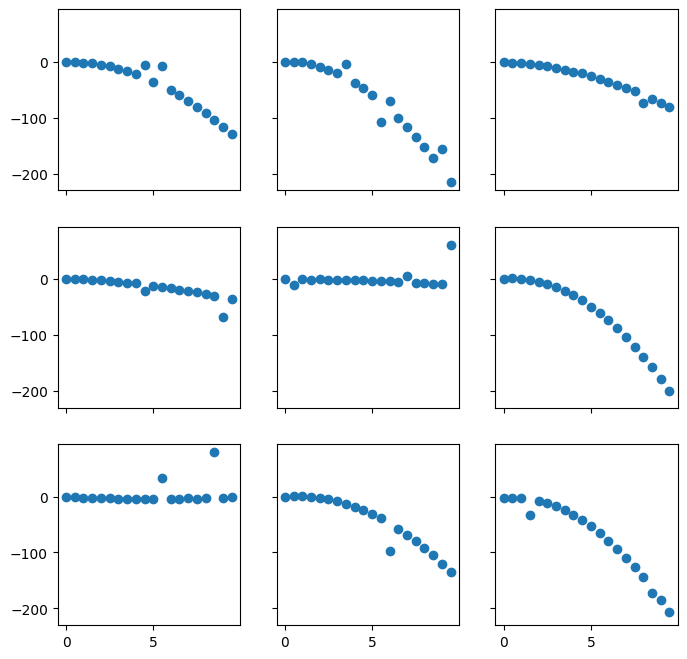

In [11]:
def visualize_prior(key, w, h):
    f, axes = plt.subplots(w, h, figsize=(8, 8), sharex=True, sharey=True)
    for ax in axes.flatten():
        key, sub_key = jax.random.split(key)
        tr = model.simulate(sub_key, (data,))
        ax.scatter(data, tr.get_retval())


key, sub_key = jax.random.split(key)
visualize_prior(sub_key, 3, 3)

Not bad. With the preliminaries out of the way, let's turn to the inference task that motivated this notebook. The idea is to observe some data in the wild--a "ground truth"--and test our hypothesis that it is a polynomial-with-outliers by inferring the parameters of our model. To do that, behind our back, we will select some polynomial coefficients and then manually inject an obvious outlying value:

In [12]:
xs = jnp.array([0.3, 0.7, 1.1, 1.4, 2.3, 2.5, 3.0, 4.0, 5.0])
ys = jnp.array(2.0 * xs + 1.5 + xs**2)
ys = ys.at[2].set(50.0)

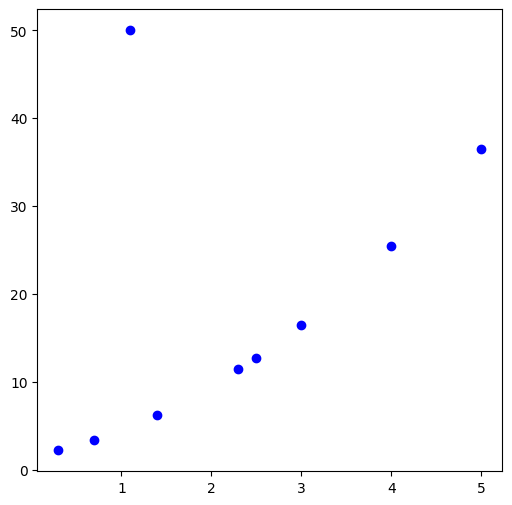

In [13]:
fig_data, ax_data = plt.subplots(figsize=(6, 6))
ax_data.scatter(xs, ys, color="blue")

### Observations
The next step is to _constrain_ the y values to the observed data while letting the _model parameters_ roam freely. To do this, we construct a [ChoiceMap](https://probcomp.github.io/genjax/genjax/library/core/datatypes.html#genjax.core.ChoiceMap). A choicemap, like a trace, stores a mapping from names of random variables to random variable values; a trace may also store other information like arguments to a generative function and its return value.

At this point, the significance of the names of the random variables we have chosen with the `@` operator becomes clear, as well as the influence of the structure of the functions we have written.  In the top-level generative function `model`, we sampled from `kernel` at address `"y"`.  In `kernel`, we sampled from either `model_y` or `outlier_model` at address `("y", i)`.  And in `model_y` and `outlier_model`, we sampled from `genjax.normal` at address `"value"`.  Thus, to refer to the $i$-th value in a trace for `model`, we can use the nested address `("ys", "y", i, "value")`.

The following code constructs a choicemap which constrains the values of the $y$'s in the model to the observed data:

In [14]:
observations = genjax.choice_map()
for i, y in enumerate(ys):
    observations = observations.insert(("ys", "y", i, "value"), y)

# Now we print out the observation choicemap
console.print(observations)

(HierarchicalChoiceMap)
└── :ys
    └── (HierarchicalChoiceMap)
        └── :y
            └── (HierarchicalChoiceMap)
                ├── :0
                │   └── (HierarchicalChoiceMap)
                │       └── :value
                │           └── (ValueChoice)
                │               └──  f32[]
                ├── :1
                │   └── (HierarchicalChoiceMap)
                │       └── :value
                │           └── (ValueChoice)
                │               └──  f32[]
                ├── :2
                │   └── (HierarchicalChoiceMap)
                │       └── :value
                │           └── (ValueChoice)
                │               └──  f32[]
                ├── :3
                │   └── (HierarchicalChoiceMap)
                │       └── :value
                │           └── (ValueChoice)
                │               └──  f32[]
                ├── :4
                │   └── (HierarchicalChoiceMap)
                │       └── :value
                │           └── (ValueChoice)
                │               └──  f32[]
                ├── :5
                │   └── (HierarchicalChoiceMap)
                │       └── :value
                │           └── (ValueChoice)
                │               └──  f32[]
                ├── :6
                │   └── (HierarchicalChoiceMap)
                │       └── :value
                │           └── (ValueChoice)
                │               └──  f32[]
                ├── :7
                │   └── (HierarchicalChoiceMap)
                │       └── :value
                │           └── (ValueChoice)
                │               └──  f32[]
                └── :8
                    └── (HierarchicalChoiceMap)
                        └── :value
                            └── (ValueChoice)
                                └──  f32[]

Currently, the way GenJAX prints out the choicemap does not show the values in it, just the datatypes; but rest assured that each `f32[]` in the above printout corresponds to a value in the observed data:

In [15]:
console.print(observations["ys", "y", 2, "value"])

50.0

GenJAX provides numerous sophisticated inference algorithms designed to operate seamlessly with generative functions. For this introduction we will content ourselves with a simple one: Sequential Importance resampling (SIR). We won't spend too much time understanding this technique--it is described greater mathematical detail in other notebooks here. Put briefly, SIR randomly generates a collection of different traces for `model`, all of which are consistent with the observed data.  Each trace will contain a different assignment to the model parameters (ie. a different quadratic function and decision of which datapoints are outliers).  We will then generate a score for each generated trace, called the _importance weight_, which has to do with how well the trace explains the data.  (That is, how likely the quadratic function and outlier assignment is to go with the data.) The `model.importance` function is used to generate and score a trace from the model.  Finally, we will use the importance weights to randomly select one of the traces, with a probability proportional to its importance weight.  The trace we select will be a random sample from an approximation to the posterior distribution over model parameters, given the observed data.

In [16]:
def sampling_importance_resampling(model, n_samples):
    def _inner(key, observations, model_args):
        """Generate a list of importance samples. Each such sample returns a tuple of
        (trace, log_weight or "score"). Treat the list as a weighted ensemble of
        choices, and draw one. This is the result of one SIR step."""
        resample_key, sub_key = jax.random.split(key)
        sub_keys = jax.random.split(sub_key, n_samples)
        tr_lw_pairs = [
            model.importance(sub_key, observations, model_args) for sub_key in sub_keys
        ]
        lws = [log_weight for (trace, log_weight) in tr_lw_pairs]
        index = genjax.categorical.sample(resample_key, lws)
        return tr_lw_pairs[index][0]

    return _inner

The next step is to "sample from the posterior." Here we will see if the SIR algorithm is converging toward an explanation of the data:

In [17]:
N = 20
model_args = (xs,)
key, *sub_keys = jax.random.split(key, N + 1)
samples = [
    sampling_importance_resampling(model, 2 * N)(sub_key, observations, model_args)
    for sub_key in sub_keys
]
coefficients = [s["alpha"] for s in samples]
coefficients

[Array([1.010287 , 0.5278951, 1.1984828], dtype=float32),
 Array([-0.9211233 ,  0.86567104,  0.87378716], dtype=float32),
 Array([-1.0745149, -1.482162 ,  1.5385957], dtype=float32),
 Array([0.84786814, 0.71207726, 0.15045144], dtype=float32),
 Array([0.57268465, 0.29548374, 1.2726619 ], dtype=float32),
 Array([2.3589952, 0.8450061, 0.6635066], dtype=float32),
 Array([0.42973506, 3.091488  , 0.96444243], dtype=float32),
 Array([-0.27574053,  0.08777174,  1.297302  ], dtype=float32),
 Array([ 0.1593281, -1.1751109,  1.2956231], dtype=float32),
 Array([-0.15748872, -0.6242661 ,  1.2884508 ], dtype=float32),
 Array([-0.86585575,  0.20120655,  1.5489457 ], dtype=float32),
 Array([-3.1770554,  1.016473 ,  0.6508961], dtype=float32),
 Array([ 0.10336191, -1.3277259 ,  1.6000715 ], dtype=float32),
 Array([0.34509325, 1.8227931 , 1.004335  ], dtype=float32),
 Array([0.78460824, 0.9772161 , 1.3039516 ], dtype=float32),
 Array([0.800835 , 2.718055 , 0.8583257], dtype=float32),
 Array([0.18771952

In [18]:
def plot_polynomial_values(ax_inf, xs, coefficients, **kwargs):
    f = polynomial(coefficients)
    ax_inf.plot(xs, [f(x) for x in xs], alpha=0.2)

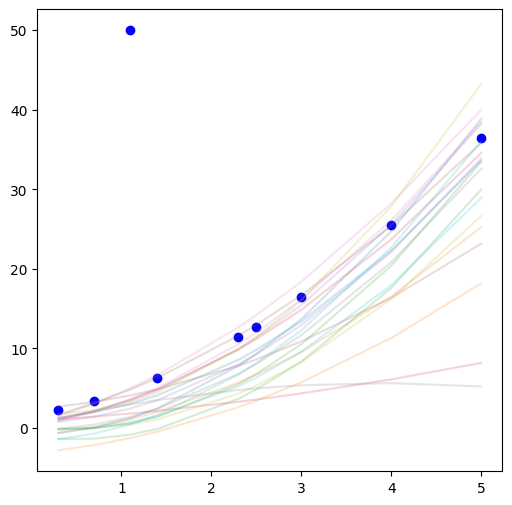

In [19]:
fig_inf, ax_inf = plt.subplots(figsize=(6, 6))
ax_inf.scatter(xs, ys, color="blue")
for cs in coefficients:
    plot_polynomial_values(ax_inf, xs, cs)

Not too bad. It appears that the sampling procedure has accomplished both of its goals: it has found plausible polynomial coefficients, and further, it has declined to allow the outlier to overly influence the result. To verify that, we can calculate what fraction of the samples classified $y_2$ as an outlier like this:

In [20]:
# Each `s` is a trace; we examine the value of whether datapoint 2 is
# an outlier for each, using the naming scheme determined by the `@`
# calls in the generative functions.
outlier_at_2 = [s["ys", "outlier", 2] for s in samples]

In [21]:
np.sum(outlier_at_2) / len(outlier_at_2)

0.95

We invite you to dive deeper into GenJAX, but learning more about how easily JAX can be used to accelerate the computation we just performed, as well as the many state of the art inference techniques the Gen system offers. 